In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d


imgL = cv2.imread('left/1585434287_770591974_Left.png')  #queryimage # left image
imgR = cv2.imread('right/1585434287_770591974_Right.png') #trainimage # right image
#imgR = cv2.flip(imgR,1) #trainimage # right image


#undistort
data1 = np.load('calib_stereo.npz')
data2 = np.load('rectified_stereo.npz')

map1x, map1y = cv2.initUndistortRectifyMap(data1['cameraMatrix1'], data1['distCoeffs1'], data2['R1'], data2['P1'],(1280, 720), cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(data1['cameraMatrix2'], data1['distCoeffs2'], data2['R2'], data2['P2'],(1280, 720), cv2.CV_32FC1)

imgL_rect = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR);
imgR_rect = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR);


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0][0].imshow(imgL)
ax[0][0].set_title('Original left image')
ax[0][1].imshow(imgR)
ax[0][1].set_title('Original right image')
ax[1][0].imshow(imgL_rect)
ax[1][0].set_title('Undistorted left cropped image')
ax[1][1].imshow(imgR_rect)
ax[1][1].set_title('Undistorted right cropped image')

smallL = cv2.resize(imgL_rect, (0,0), fx=0.5, fy=0.5) 
smallR = cv2.resize(imgR_rect, (0,0), fx=0.5, fy=0.5) 

cv2.imwrite( "left_calibrated.png", smallL);
cv2.imwrite( "right_calibrated.png", smallR);


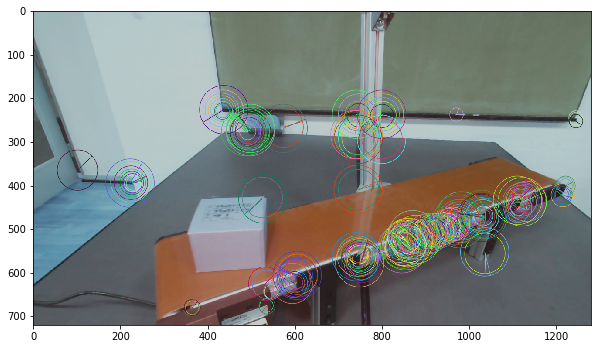

In [2]:
img1 = imgL_rect  #queryimage # left image
img2 = imgR_rect

orb = cv2.ORB_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

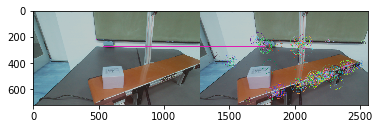

(<matplotlib.image.AxesImage at 0x7efce9007898>, None)

In [3]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], None, flags=2)

plt.imshow(img3),plt.show()

In [4]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
#    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
#    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    r,c,dummy = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

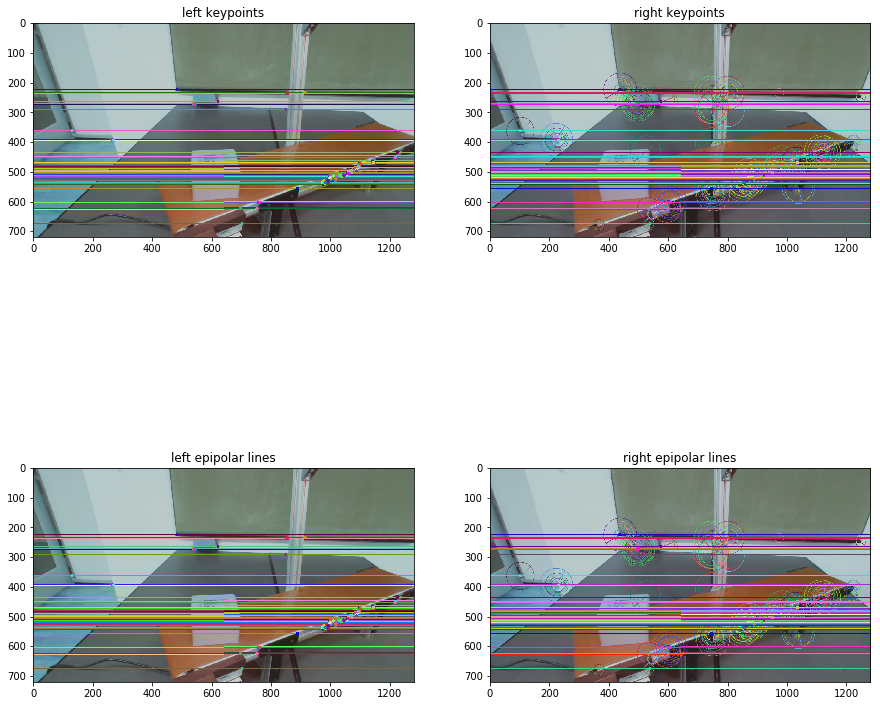

In [19]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img4), plt.title('left keypoints')
plt.subplot(222), plt.imshow(img6), plt.title('right keypoints')
plt.subplot(223), plt.imshow(img5), plt.title('left epipolar lines')
plt.subplot(224), plt.imshow(img3), plt.title('right epipolar lines')
plt.show()

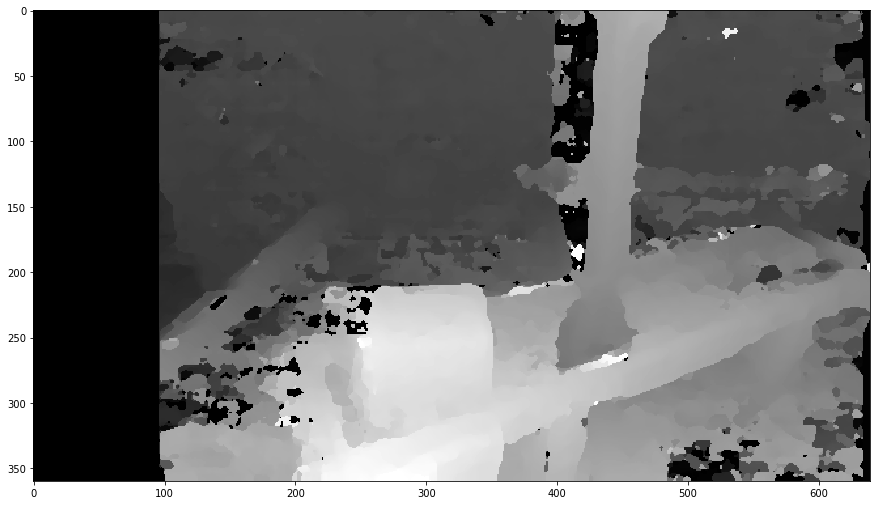

In [39]:
img1= smallL
img2= smallR


stereo = cv2.StereoSGBM_create(minDisparity = 0,
        numDisparities = 96,
        blockSize = 9,
        P1 = 477,
        P2 = 2048,
        disp12MaxDiff = 29,
        preFilterCap = 1, 
        uniquenessRatio = 0,
        speckleWindowSize = 0,
        speckleRange = 0
    )

disp = stereo.compute(img1, img2).astype(np.float32) / 16.0

plt.figure(figsize = (15,15))
plt.imshow(disp, 'gray')
plt.show()


Computing the disparity  map...


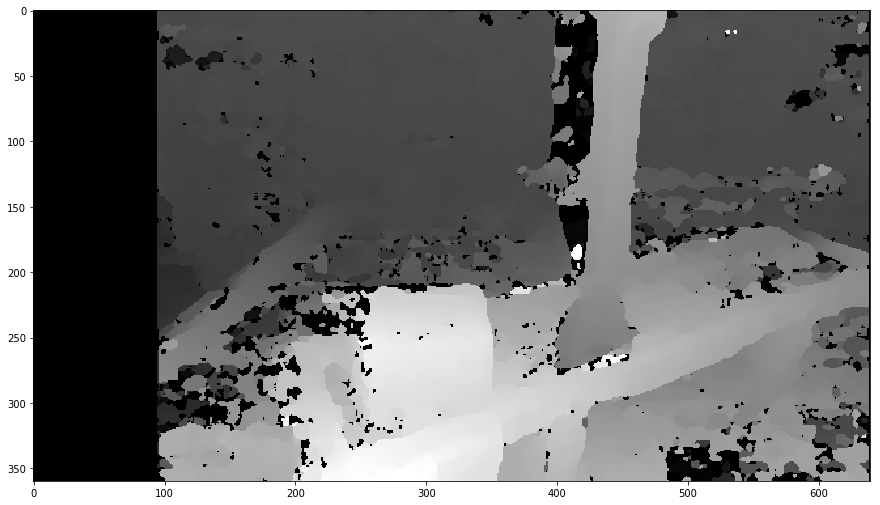

In [40]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error. 
win_size = 5
min_disp = -1
max_disp = 95 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16#Create Block matching object. 
stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 9,
 uniquenessRatio = 5,
 speckleWindowSize = 5,
 speckleRange = 5,
 disp12MaxDiff = 29,
 P1 = 8*3*win_size**2,#8*3*win_size**2,
 P2 =32*3*win_size**2) #32*3*win_size**2)#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img1, img2)


#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.figure(figsize = (15,15))
plt.imshow(disparity_map,'gray')
plt.show()

In [27]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [41]:
#Generate  point cloud. 
h,w = img1.shape[:2]

#Perspective transformation matrix
Q = data2['Q']
points_3D = cv2.reprojectImageTo3D(disparity_map, Q)
#Get color points
colors = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()#Mask colors and points. 
output_points = points_3D[mask_map]
output_colors = colors[mask_map]#Define name for output file
output_file = 'reconstructed.ply'#Generate point cloud 
write_ply(output_file, output_points, output_colors)

In [34]:
source = o3d.io.read_point_cloud("reconstructed.ply")
print(source)
o3d.visualization.draw_geometries([source])

geometry::PointCloud with 191007 points.
